In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")
from enum import Enum

In [11]:
def _processing(df, scenarios):
    global namedict
    df = df.loc[df.index.str.split("_").str[-1].isin(scenarios)].T
    df.columns = df.columns.to_series().apply(lambda value: namedict[value.split("_")[-1]])
    df.index = df.index.astype("float")
    return df


def _coi_processing(df, scenarios):
    df = _processing(df, scenarios)
    # get each year
    df = df[df.index % 1 == 0].copy()
    # only care about the difference
    return df.diff(axis=0)


def _meat_processing(df, scenarios):
    df = _processing(df, scenarios)
    if df.empty:
        return df
    min_idx, max_idx = min(df.index), max(df.index)
    # for truncation
    df = df.groupby(np.arange(len(df)) // 4, as_index=False).mean()
    idx = pd.DataFrame(np.arange(min_idx, max_idx, (max_idx - min_idx) / df.shape[0]))
    df = pd.concat([idx, df], axis=1)
    df.set_index(0, inplace=True)
    df.index.name = None
    df.index = df.index.astype("float")
    return df


def data_processing(loc):
    location = "../data/" + loc + ".txt"
    df = pd.read_csv(location, delimiter="\t", dtype="string")
    df = df.iloc[:, :-1]
    # Ok, so as we all know Python is retarded when it comes to memory allocation, which means we have to resort ugly constructs like this
    # C++ for the win
    temp = df.iloc[:, 1:].applymap(lambda value: float(value.replace("M", '')) * 1000000 if "M" in value else value)
    temp = temp.apply(pd.to_numeric)
    df = pd.concat([df.iloc[:, 0], temp], axis=1)
    # df = pd.DataFrame(df.iloc[:,0]).join(temp)
    df.set_index("Date", inplace=True)
    return df


def get_data(data, df, scenarios):
    if data.name in [DATA.COI.name, DATA.DALY.name]:
        df = pd.DataFrame(df.loc[data_df.index.str.contains(data.value)])
        return _coi_processing(df, scenarios)
    elif data.name in [DATA.COIACC.name, DATA.DALYACC.name]:
        df = pd.DataFrame(df.loc[data_df.index.str.contains(data.value[1:])])
        return _meat_processing(df, scenarios)
    else:
        df = pd.DataFrame(df.loc[data_df.index.str.contains(data.value)])
        return _meat_processing(df, scenarios)

#What's the name of ur file?
loc = "cb_data"

policydict = {"cb" : "Consumption behaviour",
             "fs" : "Food safety and handling",
             "pc": "Fly population control",
             "ec": "Exposure control",
             "ss" : "Safe slaughtering",
             "00": "without policies"}

#What's ur policy called?
policy = policydict[loc[:2]]

bw = ["base", "12"]
po = ["1", "2", "3"]
t = ["4", "5", "6"]
s = ["7","8", "9"]
pu = ["10", "11"]

scenario_dict= {"Base and Worst Case": bw,
                "Population": po,
                "Temperature": t,
                "Seasonal": s,
                "Public health": pu}

# What scenarios do u want plotted from policy?
scenarioss = [bw, po, t,s, pu]

namedict = {"base": "Base run",
            "1": "Population: medium increase",
            "2": "Population: large increase",
            "3": "Population: decrease",
            "4": "Temperature: increase 1 degree",
            "5": "Temperature: increase 1.5 degrees",
            "6": "Temperature: increase 2 degrees",
            "7": "Seasonality: no temperature change",
            "8": "Seasonality: Fast temperature change",
            "9": "Seasonality: linear temperature change",
            "10": "Public health: 10% fewer symptoms",
            "11": "Public health: 10% more symptoms",
            "12": "Worst case"}

class DATA(Enum):
    COI = "Cost of Illness"
    DALY = "DALY"
    COIACC = "aCost of Illness"
    DALYACC = "aDALY"
    MEAT = "contaminated meat"
    ENVH = "human infection from environment"
    ENVC = "rate of chicken infection from environment"

# Because we like colour consistency
simulcmap = "tab10"
cmap = plt.cm.get_cmap(simulcmap, 10)
cmapcolors = cmap(range(10))

colordict = {namedict["base"] : cmapcolors[0],
            namedict["base"] + ", w/ policy" : cmapcolors[0],
            namedict["base"] + ", w/o policy": cmapcolors[0],
            namedict["1"] : cmapcolors[0],
            namedict["1"] + ", w/ policy"  : cmapcolors[0],
            namedict["1"] + ", w/o policy" : cmapcolors[0],
            namedict["2"] :  cmapcolors[1],
            namedict["2"] + ", w/ policy"  :  cmapcolors[1],
            namedict["2"] + ", w/o policy" : cmapcolors[1],
            namedict["3"] :  cmapcolors[2],
            namedict["3"] + ", w/ policy" : cmapcolors[2],
            namedict["3"] + ", w/o policy" : cmapcolors[2],
            namedict["4"] :  cmapcolors[3],
            namedict["4"] + ", w/ policy" :  cmapcolors[3],
            namedict["4"]  + ", w/o policy"  :  cmapcolors[3],
            namedict["5"] :  cmapcolors[0],
            namedict["5"] + ", w/ policy" : cmapcolors[0],
            namedict["5"]  + ", w/o policy"  : cmapcolors[0],
            namedict["6"] :  cmapcolors[4],
            namedict["6"] + ", w/ policy" :  cmapcolors[4],
            namedict["6"] + ", w/o policy" :  cmapcolors[4],
            namedict["7"] :  cmapcolors[5],
            namedict["7"] + ", w/ policy" : cmapcolors[5],
            namedict["7"] + ", w/o policy"  : cmapcolors[5],
            namedict["8"] : cmapcolors[6],
            namedict["8"] + ", w/ policy" :  cmapcolors[6],
            namedict["8"] + ", w/o policy"  :  cmapcolors[6],
            namedict["9"] :  cmapcolors[0],
            namedict["9"] + ", w/ policy" : cmapcolors[0],
            namedict["9"] + ", w/o policy"  : cmapcolors[0],
            namedict["10"] :  cmapcolors[7],
            namedict["10"] + ", w/ policy" : cmapcolors[7],
            namedict["10"] + ", w/o policy"  : cmapcolors[7],
            namedict["11"] :  cmapcolors[9],
            namedict["11"] + ", w/ policy" : cmapcolors[9],
            namedict["11"] + ", w/o policy"  : cmapcolors[9],
            namedict["12"] : cmapcolors[8],
            namedict["12"] + ", w/ policy" : cmapcolors[8],
            namedict["12"] + ", w/o policy"  :  cmapcolors[8]}



In [12]:
data = []
loc= "00_data"
scenarios = ["base"]
policy = policydict[loc[:2]]
data_df = data_processing(loc)

In [43]:
i=6

## Accumulated cost of illness

In [65]:
df = get_data(DATA.COIACC, data_df, scenarios)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

df[df.columns[0]] /= 1000000
sns.lineplot(data=df.loc[df.index >= 2021.75], dashes=[(1, 0)] * len(scenarios), palette= [cmapcolors[i]] * df.shape[1], linewidth = 2)
    
plt.xlabel('Year');
plt.ylabel('Cost (million euro)')
plt.title("Base run " + policy + ': Accumulated Cost of Illness')
plt.legend('')

ax.grid(True)
plt.savefig("../images/br_acoi.png", dpi=300, bbox_inches='tight')
plt.show()

## Cost of illness

In [39]:
df = get_data(DATA.COI, data_df, scenarios)

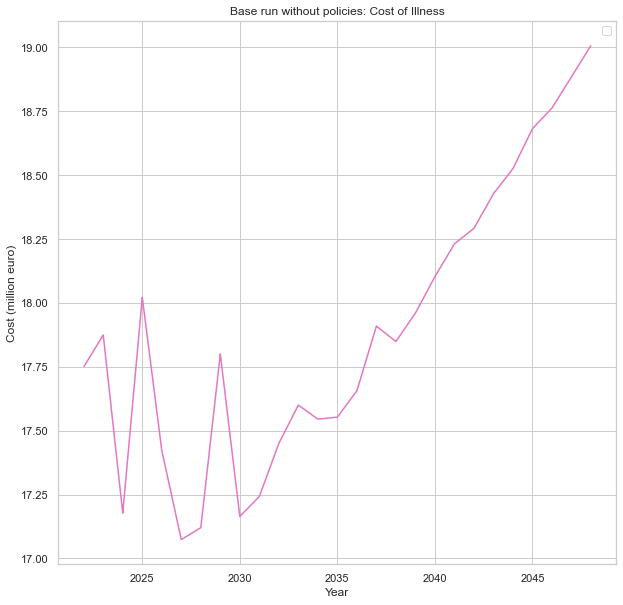

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))

df[df.columns[0]] /= 1000000
sns.lineplot(data=df.loc[df.index >= 2021.75], dashes=[(1, 0)] * len(scenarios), palette= [cmapcolors[i]] * df.shape[1], linewidth = 2)
    
plt.xlabel('Year');
plt.ylabel('Cost (million euro)')
plt.title("Base run " + policy + ': Cost of Illness')
plt.legend('')

ax.grid(True)
plt.savefig("../images/wc_coi.png", dpi=300, bbox_inches='tight')
plt.show()

# Meat

In [63]:
df = get_data(DATA.MEAT, data_df, scenarios)

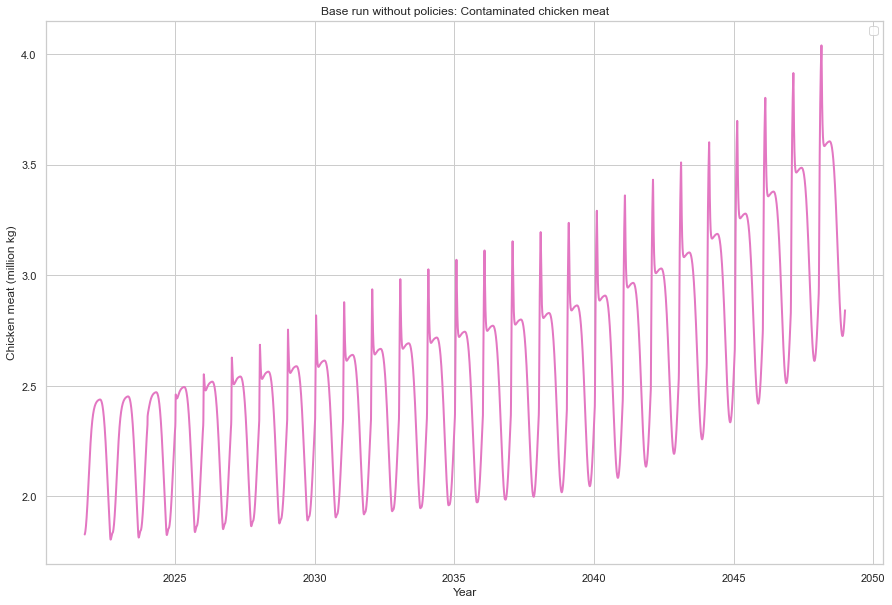

In [64]:
fig, ax = plt.subplots(figsize=(15, 10))

df[df.columns[0]] /= 1000000
sns.lineplot(data=df.loc[df.index >= 2021.75], dashes=[(1, 0)] * len(scenarios), palette= [cmapcolors[i]] * df.shape[1], linewidth = 2)
    
plt.xlabel('Year');
plt.ylabel('Chicken meat (million kg)')
plt.title("Base run " + policy + ': Contaminated chicken meat')
plt.legend('')

ax.grid(True)
plt.savefig("../images/br_meat.png", dpi=300, bbox_inches='tight')
plt.show()

# Infections humans

In [61]:
df = get_data(DATA.ENVH, data_df, scenarios)

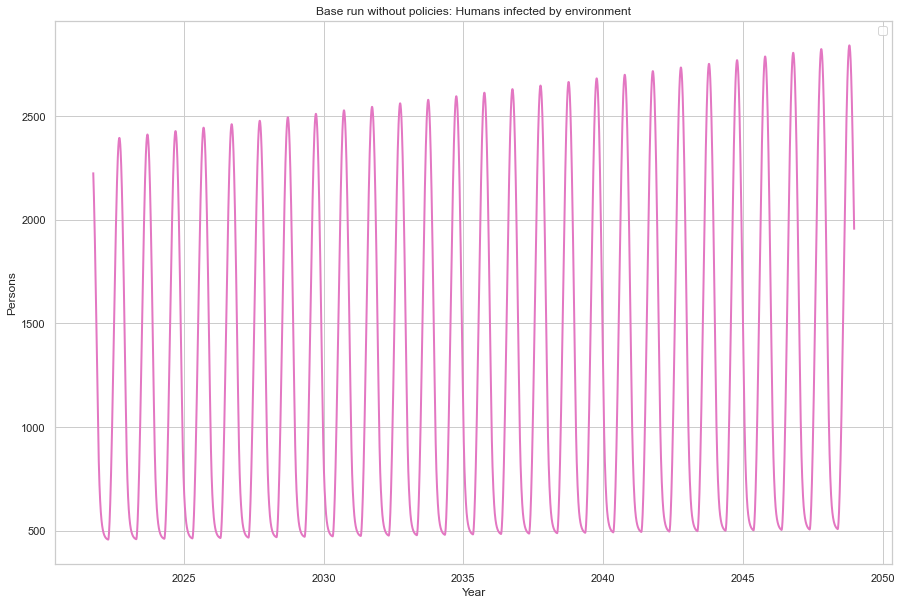

In [62]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(data=df.loc[df.index >= 2021.75], dashes=[(1, 0)] * len(scenarios), palette= [cmapcolors[i]] * df.shape[1], linewidth = 2)
    
plt.xlabel('Year');
plt.ylabel('Persons')
plt.title("Base run " + policy + ': Humans infected by environment')
plt.legend('')

ax.grid(True)
plt.savefig("../images/br_humaninfection.png", dpi=300, bbox_inches='tight')
plt.show()

# Infections chickens

In [59]:
df = get_data(DATA.ENVC, data_df, scenarios)

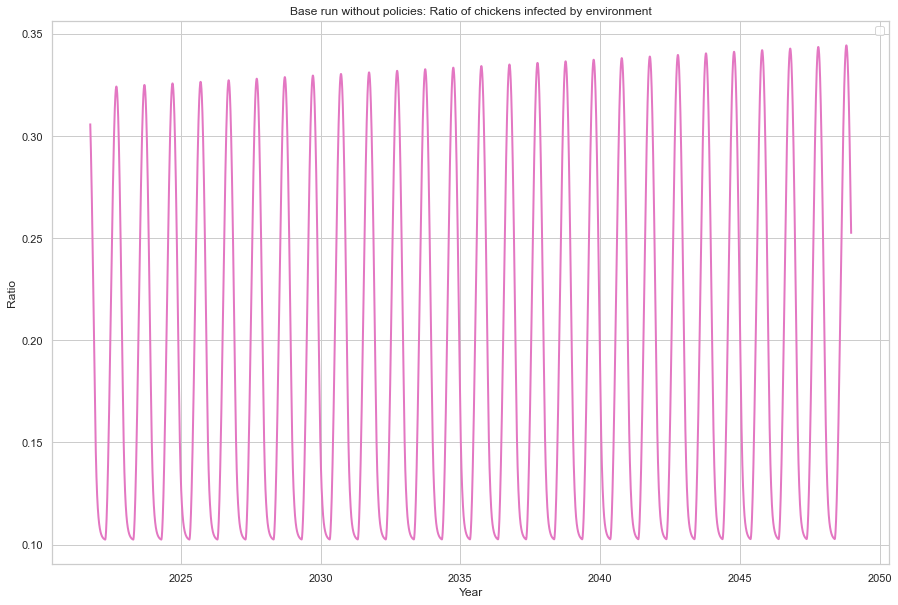

In [60]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(data=df.loc[df.index >= 2021.75], dashes=[(1, 0)] * len(scenarios), palette= [cmapcolors[i]] * df.shape[1], linewidth = 2)
    
plt.xlabel('Year');
plt.ylabel('Ratio')
plt.title("Base run " + policy + ': Ratio of chickens infected by environment')
plt.legend('')

ax.grid(True)
plt.savefig("../images/br_chickeninfection.png", dpi=300, bbox_inches='tight')
plt.show()